In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Local modules
sys.path.append('../src')
from train import train_model
from visualize import imshow, visualize_model
from utils import unpickle, save_pickle

In [2]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms


In [3]:
# Script runtime options
root_dir = '..' # '/home/jupyter/caltech_birds'
model = 'resnet152'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [4]:
# Get data transforms
data_transforms = makeTransforms()

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

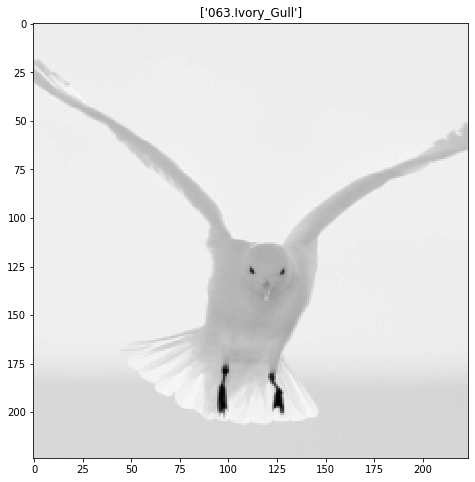

In [7]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Load the extracted feature maps
feature_maps_dict = unpickle(os.path.join(output_dir,'resnet152_feature_extractions.pkl'))
features = np.array(feature_maps_dict['feature extractions']).squeeze()

In [9]:
features.shape

(5794, 2048)

In [10]:
feature_maps_dict.keys()

dict_keys(['labels truth', 'labels pred', 'image paths', 'feature extractions'])

# Domain Reduction - Principal Components Analysis

## Assess all components

Compute all components to assess the number of components required to reconstruct 95% of the feature map information.

In [11]:
# Domain reduction
from sklearn.decomposition import PCA

In [12]:
pca = PCA()
pca.fit(features)

PCA()

In [13]:
cum_explained_variance_ratio= []
cumsum=0.
for comp in pca.explained_variance_ratio_:
    cumsum += comp
    cum_explained_variance_ratio.append( cumsum )

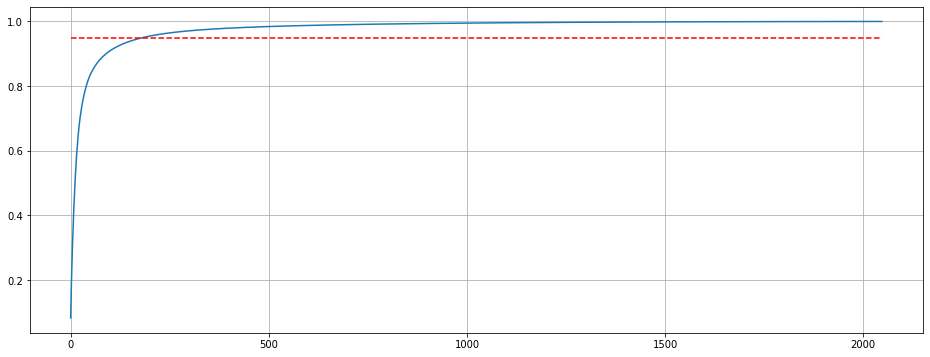

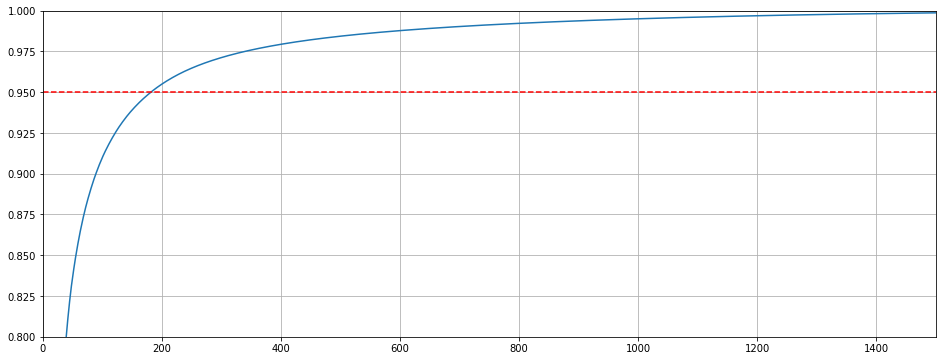

In [14]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.show()

plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.ylim([0.8,1.0])
plt.xlim([0, 1500])
plt.show()

## Compute the PCA transform and apply to the feature maps

200 components was found to recover ~95% of the variance in the data.
This is domain reduction from 2048 to 200 dimensions.

In [15]:
pca = PCA(n_components=200)
pca.fit(features)

PCA(n_components=200)

In [16]:
pca_features = pca.transform(features)

In [17]:
pca_features.shape

(5794, 200)

In [18]:
pca_features_dict = {'pca_features' : pca_features,
                     'pca_model' : pca,
                     'n_components' : 200,
                     'cumulative explained variance ratio (all components)' : cum_explained_variance_ratio}

In [19]:
save_pickle(pca_features_dict, os.path.join(output_dir,'{}_pca_feature_extractions.pkl'.format(model)))

# Transfer Learning

In this section, we are going to use the final layer neuron activations as the inputs into more advanced classifiers compared to the final layer linear classification of the neural network.

We will try the following algorithms:

    1. Ensemble methods, bagging and boosting trees (Random Forests, XGBoost).
    2. Naive Bayes.
    3. Support Vector Machines (Linear SVM, Kernel SVM).

## Ensemble methods

In [23]:
pca_features_df = pd.DataFrame(pca_features)
pca_features_df['class'] = feature_maps_dict['labels truth']

In [24]:
pca_features_df

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
0,-2.340913,-7.672448,0.949921,-3.878863,-7.883251,0.734743,-0.430547,3.484348,-3.069120,2.513498,...,0.273585,-0.446021,0.269927,0.061581,-0.008182,-0.679197,-0.017455,-0.240578,0.133228,94
1,12.950356,-0.257184,-2.209015,0.214118,2.895335,-0.765873,7.048082,-1.794454,-6.527338,2.631279,...,0.096642,0.262545,-0.228361,-0.061070,-0.203103,0.044846,-0.225802,-0.286268,0.372016,85
2,-1.831528,-4.069939,2.329014,-2.327717,-5.130707,-5.862796,-0.849731,10.559089,6.814944,2.396259,...,0.108857,0.592565,0.782416,-0.789427,-0.248772,-0.231782,0.024164,-0.069653,-0.674037,16
3,1.842750,-4.656497,9.081046,-1.941489,-5.055465,2.290452,-1.172728,-5.220215,-1.094338,3.700841,...,-0.162470,0.136372,-0.166217,-0.589715,-0.137089,-0.311483,0.000470,0.076999,0.290365,12
4,2.138802,7.412910,2.178982,6.832223,-1.335763,-5.467328,-5.104925,-7.543977,-1.318406,1.610141,...,-0.382647,0.001787,-0.034385,0.002301,-0.096830,0.108549,0.166227,-0.115996,0.205968,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5789,2.450014,-0.055394,1.306996,9.185514,-6.195904,3.901289,-4.008814,-5.361973,4.579132,-0.044272,...,0.004061,-0.211052,0.374835,0.063715,0.120606,-0.283952,0.054363,-0.488568,-0.369952,111
5790,-10.484981,4.990171,-4.328361,2.283035,9.750954,-6.271725,-1.223107,-2.206990,6.546447,-1.511014,...,-0.042661,-0.183259,-0.466208,0.450689,0.692718,-0.016321,0.075409,-0.090518,-0.946290,177
5791,7.887292,-1.439308,-7.378586,2.943650,-6.096135,7.651026,0.622585,2.905882,-1.512707,-4.779255,...,0.128179,-0.151521,0.288612,-0.526162,-0.347834,-0.582443,-0.204445,-0.172670,-0.149155,144
5792,-5.510771,10.783571,-2.110001,6.142437,-7.814809,-7.361775,-2.601324,-2.352343,5.051126,-3.075793,...,0.463044,0.462558,0.398610,0.068375,-0.164691,0.282962,0.422732,0.230850,-0.072033,115


In [25]:
from sklearn.model_selection import train_test_split
# Split the data into test and train sets (75% train, 25% test), making sure to stratify the sampling on class.
X_train, X_test, y_train, y_test = train_test_split(pca_features_df.drop(labels=['class'], axis=1), pca_features_df['class'], test_size=0.25, random_state=42, stratify=pca_features_df['class'])

In [39]:
# Check the sampling is relatively balanced across all the classes
for i in np.arange(1,len(class_names),1):
    print('samples: {:4} :: class: {:4} :: class name: {}'.format((y_train == i).sum(), i, class_names[i-1]))

samples:   22 :: class:    1 :: class name: 001.Black_footed_Albatross
samples:   21 :: class:    2 :: class name: 002.Laysan_Albatross
samples:   23 :: class:    3 :: class name: 003.Sooty_Albatross
samples:   11 :: class:    4 :: class name: 004.Groove_billed_Ani
samples:    8 :: class:    5 :: class name: 005.Crested_Auklet
samples:   17 :: class:    6 :: class name: 006.Least_Auklet
samples:   14 :: class:    7 :: class name: 007.Parakeet_Auklet
samples:   22 :: class:    8 :: class name: 008.Rhinoceros_Auklet
samples:   22 :: class:    9 :: class name: 009.Brewer_Blackbird
samples:   22 :: class:   10 :: class name: 010.Red_winged_Blackbird
samples:   20 :: class:   11 :: class name: 011.Rusty_Blackbird
samples:   22 :: class:   12 :: class name: 012.Yellow_headed_Blackbird
samples:   22 :: class:   13 :: class name: 013.Bobolink
samples:   21 :: class:   14 :: class name: 014.Indigo_Bunting
samples:   21 :: class:   15 :: class name: 015.Lazuli_Bunting
samples:   20 :: class:   1

In [42]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRFClassifier

### Random Forest Classifier

In [59]:
for n_est in [50,100,200,400,500,1000,1500,2000]:
    rf_clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=n_est, n_jobs=4)
    rf_clf.fit(X_train, y_train)
    print('{:6} number of estimators, Train Accuracy:: {:0.4f}, Test Accuracy:: {:0.4f}'.format(n_est, rf_clf.score(X=X_train, y=y_train),rf_clf.score(X=X_test, y=y_test)))

    50 number of estimators, Train Accuracy:: 0.4483, Test Accuracy:: 0.3803
   100 number of estimators, Train Accuracy:: 0.5349, Test Accuracy:: 0.4527
   200 number of estimators, Train Accuracy:: 0.5763, Test Accuracy:: 0.4997
   400 number of estimators, Train Accuracy:: 0.6078, Test Accuracy:: 0.5369
   500 number of estimators, Train Accuracy:: 0.6184, Test Accuracy:: 0.5514
  1000 number of estimators, Train Accuracy:: 0.6587, Test Accuracy:: 0.5769
  1500 number of estimators, Train Accuracy:: 0.6663, Test Accuracy:: 0.5811
  2000 number of estimators, Train Accuracy:: 0.6635, Test Accuracy:: 0.5839


In [61]:
for max_d in [8,10,12,14]:
    rf_clf = RandomForestClassifier(max_depth=max_d, random_state=0, n_estimators=1500, n_jobs=4)
    rf_clf.fit(X_train, y_train)
    print('{:6} maximum depth, Train Accuracy:: {:0.4f}, Test Accuracy:: {:0.4f}'.format(max_d, rf_clf.score(X=X_train, y=y_train),rf_clf.score(X=X_test, y=y_test)))

     8 maximum depth, Train Accuracy:: 0.9712, Test Accuracy:: 0.7640
    10 maximum depth, Train Accuracy:: 0.9908, Test Accuracy:: 0.7702
    12 maximum depth, Train Accuracy:: 0.9979, Test Accuracy:: 0.7840
    14 maximum depth, Train Accuracy:: 1.0000, Test Accuracy:: 0.7916


### Gradient Boosting Machine

In [68]:
for n_est in [50,100,200,400,500,1000,1500,2000]:
    gb_clf = GradientBoostingClassifier(random_state=0, n_estimators=n_est, verbose=1, max_depth=2)
    gb_clf.fit(X_train, y_train)
    print('{:6} number of estimators, Train Accuracy:: {:0.4f}, Test Accuracy:: {:0.4f}'.format(n_est, gb_clf.score(X=X_train, y=y_train),gb_clf.score(X=X_test, y=y_test)))

      Iter       Train Loss   Remaining Time 
         1       13228.5870           29.74m
         2       57304.7829           30.69m
         3 1241801383086674802865811716420130432643713246867227866472369300282811134538704007021898682037376735606090075853782102573056.0000           31.72m
         4 1241801383086674802865811716420130432643713246867227866472369300282811134538704007021898682037376735606090075853782102573056.0000           30.51m


KeyboardInterrupt: 

In [67]:
for n_est in [50,100,200,400,500,1000,1500,2000]:
    xgb_clf = XGBClassifier(random_state=0, n_estimators=n_est, verbose=1, n_jobs=4, max_depth=2)
    xgb_clf.fit(X_train, y_train)
    print('{:6} number of estimators, Train Accuracy:: {:0.4f}, Test Accuracy:: {:0.4f}'.format(n_est, gb_clf.score(X=X_train, y=y_train),gb_clf.score(X=X_test, y=y_test)))

[23:37:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




KeyboardInterrupt: 

In [69]:
from sklearn.svm import LinearSVC, SVC

In [74]:
sv_clf = SVC(C=1.0, kernel='linear', random_state=0, verbose=1)
sv_clf.fit(X_train, y_train)
print('Train Accuracy:: {:0.4f}, Test Accuracy:: {:0.4f}'.format(sv_clf.score(X=X_train, y=y_train),sv_clf.score(X=X_test, y=y_test)))

[LibSVM]Train Accuracy:: 1.0000, Test Accuracy:: 0.7909


In [75]:
sv_clf = SVC(C=1.0, kernel='sigmoid', random_state=0, verbose=1)
sv_clf.fit(X_train, y_train)
print('Train Accuracy:: {:0.4f}, Test Accuracy:: {:0.4f}'.format(sv_clf.score(X=X_train, y=y_train),sv_clf.score(X=X_test, y=y_test)))

[LibSVM]Train Accuracy:: 0.8534, Test Accuracy:: 0.7930


In [73]:
sv_clf = SVC(C=1.0, kernel='rbf', random_state=0, verbose=1)
sv_clf.fit(X_train, y_train)
print('Train Accuracy:: {:0.4f}, Test Accuracy:: {:0.4f}'.format(sv_clf.score(X=X_train, y=y_train),sv_clf.score(X=X_test, y=y_test)))

[LibSVM]Train Accuracy:: 0.9261, Test Accuracy:: 0.8068
